
*Boutaj Sofiène - Darmon Salhia - Katturaja 
Amarnathe*

# Introduction

For this project, we decided to process data from an online survey, in order to handle real data. The survey from which the data is from covers the annual salary of managers working in different industries and having different characteristics in all over the United States. Using the data we first want to study the characteristics that influence the salary and to what extent. Then in a second step, we want to be able to forecast the wage of a person from several pieces of information.




# Importation of libraries and of the dataset



In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import Birch
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

from random import randint
import random as rd

from sklearn.metrics import f1_score
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1neVm9eAy9cTxZXFy_w_tRkCcJXH8ZfcU',
  dest_path='./Ask-A-Manager-Salary-Survey-2021-Responses-Form-Responses-1.csv')

else: 
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')


# Cleaning

In [ ]:
df = pd.read_csv('/content/Ask-A-Manager-Salary-Survey-2021-Responses-Form-Responses-1.csv')
print(df.shape)
df.head()

(27508, 18)


,Timestamp,How old are you?,Industry,Job title,Additional context on job title,Annual salary,Other monetary comp,Currency,Currency - other,Additional context on income,Country,State,City,Overall years of professional experience,Years of experience in field,Highest level of education completed,Gender,Race
0,4/27/2021 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,"55,000",0.0,USD,NaN,NaN,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White
1,4/27/2021 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,NaN,"54,600",4000.0,GBP,NaN,NaN,United Kingdom,NaN,Cambridge,8 - 10 years,5-7 years,College degree,Non-binary,White
2,4/27/2021 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,"34,000",NaN,USD,NaN,NaN,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
3,4/27/2021 11:02:41,25-34,Nonprofits,Program Manager,NaN,"62,000",3000.0,USD,NaN,NaN,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White
4,4/27/2021 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,"60,000",7000.0,USD,NaN,NaN,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White


In [ ]:
df.columns = ['date', 'age', 'industry', 'job', 'context', 
              'wage', 'money_component', 'currency', 'other_currency', 'income_context', 
              'country', 'state', 'city', 'total_experience', 'field_experience',
              'education', 'gender', 'race']

df.head()

,date,age,industry,job,context,wage,money_component,currency,other_currency,income_context,country,state,city,total_experience,field_experience,education,gender,race
0,4/27/2021 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,"55,000",0.0,USD,NaN,NaN,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White
1,4/27/2021 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,NaN,"54,600",4000.0,GBP,NaN,NaN,United Kingdom,NaN,Cambridge,8 - 10 years,5-7 years,College degree,Non-binary,White
2,4/27/2021 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,"34,000",NaN,USD,NaN,NaN,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
3,4/27/2021 11:02:41,25-34,Nonprofits,Program Manager,NaN,"62,000",3000.0,USD,NaN,NaN,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White
4,4/27/2021 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,"60,000",7000.0,USD,NaN,NaN,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27508 entries, 0 to 27507
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              27508 non-null  object 
 1   age               27508 non-null  object 
 2   industry          27440 non-null  object 
 3   job               27508 non-null  object 
 4   context           7124 non-null   object 
 5   wage              27508 non-null  object 
 6   money_component   20394 non-null  float64
 7   currency          27508 non-null  object 
 8   other_currency    180 non-null    object 
 9   income_context    2997 non-null   object 
 10  country           27508 non-null  object 
 11  state             22616 non-null  object 
 12  city              27433 non-null  object 
 13  total_experience  27508 non-null  object 
 14  field_experience  27508 non-null  object 
 15  education         27302 non-null  object 
 16  gender            27345 non-null  object

In [ ]:
print('The perc. of empty values')
for column_name in df:
    percentage_na = df[column_name].isna().mean() * 100
    print(f'{column_name} : {np.round(percentage_na,2)} %')

The perc. of empty values
date : 0.0 %
age : 0.0 %
industry : 0.25 %
job : 0.0 %
context : 74.1 %
wage : 0.0 %
money_component : 25.86 %
currency : 0.0 %
other_currency : 99.35 %
income_context : 89.1 %
country : 0.0 %
state : 17.78 %
city : 0.27 %
total_experience : 0.0 %
field_experience : 0.0 %
education : 0.75 %
gender : 0.59 %
race : 0.57 %


We can notice that 'context', 'money_component' 'other_currency', 'income_context' have a lot of missing values. Moreover, they did not give us relevent information in our process. Thus we can just drop them. 

About the state feature, it could be interesting to exploit it event if we have 18% missing value. Thus, for the time being we will keep those rows, and when it will be time to deal with this data we will drop the missing rows. 

Finally, with a rate of less than 1% missing values, we can drop the rows concerned by industry, city, education, gender and race missing value without any risk of bias.

In [ ]:
drop_columns = ['context','money_component','other_currency','income_context']
df = df.drop(drop_columns,1)
df.shape

(27508, 14)

In [ ]:
mask_nan = (df['education'].isna().values | df['gender'].isna().values | df['race'].isna().values | df['industry'].isna().values | df['city'].isna().values  )
df = df[~mask_nan].reset_index(drop=True)

numbers_rows = df.shape[0]
numbers_columns = df.shape[1]

print(f'Building metadata without na rows except for state : {numbers_rows} | columns : {numbers_columns}')

Building metadata without na rows except for state : 26938 | columns : 14


In [ ]:
df.describe()

,date,age,industry,job,wage,currency,country,state,city,total_experience,field_experience,education,gender,race
count,26938,26938,26938,26938,26938,26938,26938,22191,26938,26938,26938,26938,26938,26938
unique,24245,7,1180,13874,4176,11,357,128,4673,8,8,6,5,48
top,4/27/2021 11:12:58,25-34,Computing or Tech,Software Engineer,"60,000",USD,United States,California,Boston,11 - 20 years,11 - 20 years,College degree,Woman,White
freq,5,12135,4505,274,423,22480,8686,2517,751,9294,6320,13077,20720,22537


In [ ]:
drop_columns = ['date','job']
df = df.drop(drop_columns,1)
df.shape

(26938, 12)

Moreover, we can notice that there's 359 unique values for country feature. However, our study is focus on United States so let's check that.

In [ ]:
print(df['country'].unique())

['United States' 'United Kingdom' 'US' 'USA' 'Canada' 'United Kingdom '
 'usa' 'UK' 'Scotland ' 'U.S.' 'United States ' 'The Netherlands'
 'Australia ' 'us' 'Usa' 'England' 'finland' 'United States of America'
 'France' 'United states' 'Scotland' 'USA ' 'United states ' 'Germany'
 'UK ' 'united states' 'Ireland' 'India' 'Australia' 'Uk'
 'United States of America ' 'U.S. ' 'canada' 'Canada ' 'U.S>' 'ISA'
 'Argentina' 'Great Britain ' 'US ' 'United State' 'U.S.A' 'Denmark'
 'U.S.A.' 'America' 'Netherlands' 'netherlands' 'Spain' 'England '
 'united states of america' 'Ireland ' 'Switzerland' 'Netherlands '
 'Bermuda' 'Us' 'The United States' 'United State of America' 'Malaysia'
 'Mexico ' 'United Stated' 'South Africa ' 'Belgium' 'Northern Ireland'
 'u.s.' 'South Africa' 'UNITED STATES' 'united States' 'Sweden'
 'Hong Kong' 'Kuwait' 'Norway' 'Sri lanka' 'Contracts'
 'USA-- Virgin Islands' 'United Statws' 'England/UK' 'U.S'
 "We don't get raises, we get quarterly bonuses, but they periodi

In [ ]:
df1 = df[df['country'].str.startswith('u')] 
df1 = df1[df1["country"].str.contains("s|S")]

df2 = df[df['country'].str.startswith('U')]
df2 = df2[df2["country"].str.contains("s|S")]

df_usa_only= pd.concat([df1, df2])
print(df_usa_only['country'].unique())

['usa' 'us' 'united states' 'united states of america' 'u.s.'
 'united States' 'united states ' 'united stated' 'usa ' 'uSA' 'uS'
 'United States' 'US' 'USA' 'U.S.' 'United States ' 'Usa'
 'United States of America' 'United states' 'USA ' 'United states '
 'United States of America ' 'U.S. ' 'U.S>' 'US ' 'United State' 'U.S.A'
 'U.S.A.' 'Us' 'United State of America' 'United Stated' 'UNITED STATES'
 'USA-- Virgin Islands' 'United Statws' 'U.S' 'Unites States ' 'Usa '
 'U.S.A. ' 'U. S. ' 'United Sates' 'United States of American '
 'Uniited States' 'United Sates of America'
 'United States (I work from home and my clients are all over the US/Canada/PR'
 'Unted States' 'United Statesp' 'United Stattes' 'United Statea'
 'United Statees' 'Uniyed states' 'Uniyes States'
 'United States of Americas' 'Unites States' 'U. S.' 'US of A'
 'United States of america ' 'United Arab Emirates ' 'U.SA'
 'United Status' 'U.s.' 'U.s.a.' 'USS' 'Uniteed States' 'United Stares'
 'UK for U.S. company' 'Unite

After this first filter which selected all the countries's name starting by the letter u, we have to drop those different from our target country. 

We can easly removed UK by filtering countries that contains the letter k.

In [ ]:
df_usa_only = df_usa_only[~(df_usa_only['country'].str.contains('K|k|Emirates'))]

In [ ]:
print(df_usa_only.shape)
print(df_usa_only['country'].unique())

(22274, 12)
['usa' 'us' 'united states' 'united states of america' 'u.s.'
 'united States' 'united states ' 'united stated' 'usa ' 'uSA' 'uS'
 'United States' 'US' 'USA' 'U.S.' 'United States ' 'Usa'
 'United States of America' 'United states' 'USA ' 'United states '
 'United States of America ' 'U.S. ' 'U.S>' 'US ' 'United State' 'U.S.A'
 'U.S.A.' 'Us' 'United State of America' 'United Stated' 'UNITED STATES'
 'USA-- Virgin Islands' 'United Statws' 'U.S' 'Unites States ' 'Usa '
 'U.S.A. ' 'U. S. ' 'United Sates' 'United States of American '
 'Uniited States' 'United Sates of America' 'Unted States'
 'United Statesp' 'United Stattes' 'United Statea' 'United Statees'
 'Uniyed states' 'Uniyes States' 'United States of Americas'
 'Unites States' 'U. S.' 'US of A' 'United States of america ' 'U.SA'
 'United Status' 'U.s.' 'U.s.a.' 'USS' 'Uniteed States' 'United Stares'
 'Unites states ' 'Us ' 'Unite States' 'United states of America '
 'UnitedStates' 'United States of america' 'United stat

In [ ]:
df_usa_only[df_usa_only['currency'] != 'USD']['currency'].count() #We count the number of rows that do not have 'USD' as currency.

22

We only have 22 rows that do not have 'USD' as currency, so we can delete them


In [ ]:
df_usa_only = df_usa_only[df_usa_only['currency'] == 'USD']

In [ ]:
drop_columns = ['country','currency']
df_usa_only = df_usa_only.drop(drop_columns,1)

Now that we clean up our data, let's look again at the state feature 

In [ ]:
percentage_na = df_usa_only['state'].isna().mean() * 100
print(f'state : {np.round(percentage_na,2)} %')

state : 0.67 %


In [ ]:
df = df_usa_only[~df_usa_only.state.isna()]

In [ ]:
df.describe()

,age,industry,wage,state,city,total_experience,field_experience,education,gender,race
count,22102,22102,22102,22102,22102,22102,22102,22102,22102,22102
unique,7,998,3432,128,3640,8,8,6,5,45
top,25-34,Computing or Tech,"70,000",California,Boston,11 - 20 years,11 - 20 years,College degree,Woman,White
freq,9812,3572,336,2504,746,7731,5242,10828,17270,18478


In [ ]:
df.head()

,age,industry,wage,state,city,total_experience,field_experience,education,gender,race
16,45-54,Art & Design,"59,000",California,Pomona,21 - 30 years,21 - 30 years,College degree,Woman,White
150,45-54,Insurance,"73,000",Colorado,Denver,31 - 40 years,31 - 40 years,High School,Woman,White
301,35-44,Government and Public Administration,"70,000",Massachusetts,Boston,8 - 10 years,8 - 10 years,Master's degree,Woman,White
309,18-24,Law,"65,000",Minnesota,Minneapolis,2 - 4 years,2 - 4 years,Master's degree,Woman,White
421,35-44,Law,"120,000",New York,I work remotely,11 - 20 years,8 - 10 years,Master's degree,Woman,"Hispanic, Latino, or Spanish origin"


# Statistical analysis

In [ ]:
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22102 entries, 0 to 22101
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               22102 non-null  object
 1   industry          22102 non-null  object
 2   wage              22102 non-null  object
 3   state             22102 non-null  object
 4   city              22102 non-null  object
 5   total_experience  22102 non-null  object
 6   field_experience  22102 non-null  object
 7   education         22102 non-null  object
 8   gender            22102 non-null  object
 9   race              22102 non-null  object
dtypes: object(10)
memory usage: 1.7+ MB


We can remark that our data are object type and that the annual salary is given with a coma to separate "les milliers et le reste". So we have to fix that to exploit data.

In [ ]:
df = df.apply(lambda x: x.str.replace(',',''))

Now that our data is clean, we can do some statistics to better understand them. 

*    We can first take a look at non numerical variables : gender, race, state, industry. 




In [ ]:
print((df.groupby('gender').size()/df['gender'].count())*100)

df.loc[df['gender'] == 'Woman', 'gender'] = 1
df.loc[df['gender'] == 'Man', 'gender'] = 0
df.loc[df['gender'] == 'Non-binary', 'gender'] = 0
df.loc[df['gender'] == 'Other or prefer not to answer', 'gender'] = 0
df.loc[df['gender'] == 'Prefer not to answer', 'gender'] = 0

df_gender = df['gender'].astype(float)
df['gender']=df_gender

gender
Man                              18.274364
Non-binary                        2.633246
Other or prefer not to answer     0.950140
Prefer not to answer              0.004524
Woman                            78.137725
dtype: float64


In [ ]:
print(((df.groupby('race').size()/df['race'].count())*100).sort_values(ascending = False).head(5)) #94.89%

df.loc[df['race'] == 'White', 'race'] = 1
df.loc[df['race'] != 1, 'race'] = 0
#df.loc[df['race'] == 'Asian or Asian American', 'race'] = 0
#df.loc[df['race'] == 'Black or African American', 'race'] = 0
#df.loc[df['race'] == 'Hispanic Latino or Spanish origin', 'race'] = 0
#df.loc[df['race'] == 'Another option not listed here or prefer not to answer', 'race'] = 0

df = df[(df.race == 0) | (df.race == 1)]
df_r = df['race'].astype(float)
df['race']=df_r

print(((df.groupby('race').size()/df['race'].count())*100).sort_values(ascending = False)) 

race
White                                                     83.603294
Asian or Asian American                                    4.669261
Black or African American                                  2.492987
Hispanic Latino or Spanish origin                          2.203421
Another option not listed here or prefer not to answer     1.900281
dtype: float64
race
1.0    83.603294
0.0    16.396706
dtype: float64


En prenant la liste des 51 réponses les plus représentés, on arrive à avoir 51 des 52 états, donc aucun doublons. En effet le fait que certaines personnes aient entré à la main l'information fait qu'on perd des informatiosn du au différentes possibilités d'écriture. Ici la liste qu'on obtient représente 99.5% des réponses, la perte d'information est minimales.
(add .sum() à ligne suivante).

In [ ]:
((df.groupby('state').size()/df['state'].count())*100).sort_values(ascending = False).head(51)

state
California              11.329291
New York                 9.460682
Massachusetts            6.655506
Texas                    5.424848
Illinois                 5.221247
Washington               5.185051
District of Columbia     4.284680
Pennsylvania             4.130848
Virginia                 3.434078
Minnesota                3.149036
Ohio                     2.836847
Oregon                   2.750882
Colorado                 2.732784
North Carolina           2.624197
Maryland                 2.443218
Michigan                 2.388924
Georgia                  2.293910
Florida                  2.253190
Wisconsin                2.040539
New Jersey               1.665008
Missouri                 1.465931
Indiana                  1.411637
Arizona                  1.339245
Tennessee                1.235182
Connecticut              1.036105
Utah                     0.909420
Kentucky                 0.805357
Iowa                     0.782735
Kansas                   0.669623
South Ca

In [ ]:
state = ['California','New York','Massachusetts','Texas','Illinois','Washington','District of Columbia','Pennsylvania','Virginia','Minnesota','Ohio','Oregon','Colorado','North Carolina','Maryland','Michigan','Georgia','Florida','Wisconsin','New Jersey','Missouri','Indiana','Arizona','Tennessee','Connecticut','Utah','Kentucky','Iowa','Kansas','South Carolina','Louisiana','Maine','New Hampshire','Oklahoma','Alabama','Nebraska','Idaho','New Mexico','Nevada','Rhode Island','Arkansas','Alaska','Vermont','Montana','Mississippi','Delaware','West Virginia','North Dakota','Hawaii','Wyoming','South Dakota']
df = df[df.state.isin(state)] 

In [ ]:
df1 = df.copy()

De même pour la catégorie industrie. Il y a en tout 994 différentes réponses. Afin de faire le trie efficassement on va prendre les corps de métiers les plus représentés. Ici 25 corps de professions représentent 92% des réponses (add .sum() à ligne suivante).

Au delà on commence à avoir des doublons.

In [ ]:
((df.groupby('industry').size()/df['industry'].count())*100).sort_values(ascending = False).head(25)

industry
Computing or Tech                       16.159825
Nonprofits                               9.345879
Education (Higher Education)             8.964044
Health care                              7.000318
Accounting Banking & Finance             6.350289
Government and Public Administration     6.200282
Engineering or Manufacturing             6.127551
Law                                      4.204737
Marketing Advertising & PR               3.941088
Education (Primary/Secondary)            3.141052
Business or Consulting                   2.941043
Media & Digital                          2.695577
Insurance                                1.968271
Recruitment or HR                        1.731897
Retail                                   1.727351
Property or Construction                 1.340970
Art & Design                             1.281876
Utilities & Telecommunications           1.145507
Transport or Logistics                   1.063685
Sales                                    

In [ ]:
industry = ['Computing or Tech','Nonprofits','Education (Higher Education)','Health care','Accounting Banking & Finance','Government and Public Administration','Engineering or Manufacturing','Law','Marketing Advertising & PR','Education (Primary/Secondary)','Business or Consulting','Media & Digital','Insurance','Recruitment or HR','Retail','Property or Construction','Art & Design','Utilities & Telecommunications','Transport or Logistics','Sales','Social Work','Hospitality & Events','Entertainment','Agriculture or Forestry','Leisure Sport & Tourism']
df = df[df.industry.isin(industry)] 


In order to apply our algorithm, we need to use numbers instead of strings.Therefore, we can try to map to each string, one number. For instance, every state will be associated with one number between 0 and 51.

In [ ]:
for i in range(len(state)):
    df.loc[df['state'] == state[i], 'state'] = 52 - i 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We map each industry to one number.

In [ ]:
for i in range(len(industry)):
    df.loc[df['industry'] == industry[i], 'industry'] = 25 - i 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df.head()

,age,industry,wage,state,city,total_experience,field_experience,education,gender,race
0,45-54,9,59000,52,Pomona,21 - 30 years,21 - 30 years,College degree,1.0,1.0
1,45-54,13,73000,40,Denver,31 - 40 years,31 - 40 years,High School,1.0,1.0
2,35-44,20,70000,50,Boston,8 - 10 years,8 - 10 years,Master's degree,1.0,1.0
3,18-24,18,65000,43,Minneapolis,2 - 4 years,2 - 4 years,Master's degree,1.0,1.0
4,35-44,18,120000,51,I work remotely,11 - 20 years,8 - 10 years,Master's degree,1.0,0.0


As we changed the values of the columns state and industry to numerical values, we need to change the type of the columns 

In [ ]:
df["state"] = pd.to_numeric(df["state"], downcast="float")
df["industry"] = pd.to_numeric(df["industry"], downcast="float")

In [ ]:
df = df.drop('city',1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20238 entries, 0 to 22101
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               20238 non-null  object 
 1   industry          20238 non-null  float32
 2   wage              20238 non-null  object 
 3   state             20238 non-null  float32
 4   total_experience  20238 non-null  object 
 5   field_experience  20238 non-null  object 
 6   education         20238 non-null  object 
 7   gender            20238 non-null  float64
 8   race              20238 non-null  float64
dtypes: float32(2), float64(2), object(5)
memory usage: 1.4+ MB




*   On regarde les autres feautures supposées numériques :




In [ ]:
df_wage = df['wage'].astype(str).astype(int)
df['wage']=df_wage

In [ ]:
#initial wage statistic
print('\n Initial wage statistic:')
print('Number of data:',df.wage.count())
print('Minimum salary:',df.wage.min())
print('Maximum salary:',df.wage.max())

#more statistics after filtered
print('\n statistics after filtered:')
df = df[(df.wage<500000)&(df.wage>15000)] #better define limitations ?
print('Number of data:',df.wage.count())
print('Minimum salary:',df.wage.min())
print('Maximum salary:',df.wage.max())
print('Average salary:',df.wage.mean())
print('Median salary:',df.wage.median())
print('Variance salary:',np.var(df.wage))
print('Standard deviation salary:',df.wage.std())


 Initial wage statistic:
Number of data: 20238
Minimum salary: 0
Maximum salary: 5000044

 statistics after filtered:
Number of data: 20099
Minimum salary: 15080
Maximum salary: 499945
Average salary: 91463.78859644759
Median salary: 80000.0
Variance salary: 2423975614.315662
Standard deviation salary: 49235.111679757014


Looking at the wage statistics we observed that some data doesn't hold water. Indeed  people with 5 millions revenu per year are exceptions or didn't tell the truth, or made a mistake when they filled the survey, and those who have 0$ salaray didn't work, thus they're not our target.
Therefore, we have to filter on wage to have some coherence. 

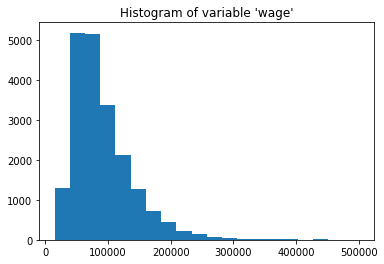

In [ ]:
plt.hist(df.wage,bins=20)
plt.title("Histogram of variable 'wage'")
plt.show()

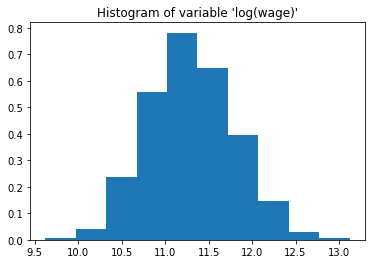

In [ ]:
plt.hist(np.log(df.wage),density=True)
plt.title("Histogram of variable 'log(wage)'")
plt.show()

Pour l'age, l'expérience et l'expérience actuelle on remplace chaque catégorie par la valeur de sa moyenne (qui est ici égale à la médianne car on suppose que l'échantillon est équi-répartie au sein d'un groupe). Pour le genre et le niveau d'éducation on attibut à chaques catégories un numéro de référence. On cast chaque column en un type float afin de pouvoir calculer la matrice de corrélation par la suite. 

In [ ]:
print((df.groupby('education').size()/df['education'].count())*100)

df.loc[df['education'] == 'High School', 'education'] = 1     #previously : 0
df.loc[df['education'] == 'Some college', 'education'] = 1     
df.loc[df['education'] == 'College degree', 'education'] = 2
df.loc[df['education'] == 'Professional degree (MD JD etc.)', 'education'] = 3
df.loc[df['education'] == "Master's degree", 'education'] = 4
df.loc[df['education'] == 'PhD', 'education'] = 5

df_edu = df['education'].astype(float)
df['education']=df_edu

print((df.groupby('education').size()/df['education'].count())*100)

#we group together 'come college' and 'high school' both do not have a diploma

education
College degree                      49.415394
High School                          1.716503
Master's degree                     32.295139
PhD                                  4.443007
Professional degree (MD JD etc.)     5.159461
Some college                         6.970496
dtype: float64
education
1.0     8.686999
2.0    49.415394
3.0     5.159461
4.0    32.295139
5.0     4.443007
dtype: float64


In [ ]:
print((df.groupby('age').size()/df['age'].count())*100)

df.loc[df['age'] == '18-24', 'age'] = 20   #previously : 21
df.loc[df['age'] == '25-34', 'age'] = 29.5
df.loc[df['age'] == '35-44', 'age'] = 39.5
df.loc[df['age'] == '45-54', 'age'] = 49.5
df.loc[df['age'] == '55-64', 'age'] = 62.5       #previously : 59.5
df.loc[df['age'] == '65 or over', 'age'] = 62.5     #previously : 70
df.loc[df['age'] == 'under 18', 'age'] = 20    #previously : 16.5

df_age = df['age'].astype(float)
df['age']=df_age

print((df.groupby('age').size()/df['age'].count())*100)

#we group under 18 and 18-24 and 65 or over with 55-64 together 

age
18-24          3.970347
25-34         44.594258
35-44         35.852530
45-54         11.532912
55-64          3.641972
65 or over     0.368178
under 18       0.039803
dtype: float64
age
20.0     4.010150
29.5    44.594258
39.5    35.852530
49.5    11.532912
62.5     4.010150
dtype: float64


In [ ]:
print((df.groupby('total_experience').size()/df['total_experience'].count())*100)

df.loc[df['total_experience'] == '1 year or less', 'total_experience'] = 2      #previously : 0.5 
df.loc[df['total_experience'] == '11 - 20 years', 'total_experience'] = 15.5
df.loc[df['total_experience'] == '2 - 4 years', 'total_experience'] = 2         #previously : 3
df.loc[df['total_experience'] == '21 - 30 years', 'total_experience'] = 36      #previously : 25.5 
df.loc[df['total_experience'] == '31 - 40 years', 'total_experience'] = 36      #previously : 35.5 
df.loc[df['total_experience'] == '41 years or more', 'total_experience'] = 36   #previously : 45.5 
df.loc[df['total_experience'] == '8 - 10 years', 'total_experience'] = 9
df.loc[df['total_experience'] == '5-7 years', 'total_experience'] = 6

df_exp = df['total_experience'].astype(float)
df['total_experience']=df_exp

print((df.groupby('total_experience').size()/df['total_experience'].count())*100)


#we group together 1 year or less with 2-4 years / then 21-30 with 31-40 and overs 41

total_experience
1 year or less       1.616996
11 - 20 years       35.255485
2 - 4 years         10.040301
21 - 30 years       13.035474
31 - 40 years        3.189213
41 years or more     0.462710
5-7 years           17.170008
8 - 10 years        19.229812
dtype: float64
total_experience
2.0     11.657296
6.0     17.170008
9.0     19.229812
15.5    35.255485
36.0    16.687397
dtype: float64


In [ ]:
print((df.groupby('field_experience').size()/df['field_experience'].count())*100)

df.loc[df['field_experience'] == '1 year or less', 'field_experience'] = 2
df.loc[df['field_experience'] == '11 - 20 years', 'field_experience'] = 15.5
df.loc[df['field_experience'] == '2 - 4 years', 'field_experience'] = 2
df.loc[df['field_experience'] == '21 - 30 years', 'field_experience'] = 36
df.loc[df['field_experience'] == '31 - 40 years', 'field_experience'] = 36
df.loc[df['field_experience'] == '41 years or more', 'field_experience'] = 36
df.loc[df['field_experience'] == '8 - 10 years', 'field_experience'] = 9
df.loc[df['field_experience'] == '5-7 years', 'field_experience'] = 6

df_ae = df['field_experience'].astype(float)
df['field_experience']=df_ae

print((df.groupby('field_experience').size()/df['total_experience'].count())*100)

#same as previously for the regroupment

field_experience
1 year or less       4.786308
11 - 20 years       23.802179
2 - 4 years         21.354296
21 - 30 years        6.806309
31 - 40 years        1.417981
41 years or more     0.144286
5-7 years           23.603164
8 - 10 years        18.085477
dtype: float64
field_experience
2.0     26.140604
6.0     23.603164
9.0     18.085477
15.5    23.802179
36.0     8.368576
dtype: float64


The number of years of experience in the field cannot be greater than the total number of years of experience. So we can delete these data. 

In [ ]:
len(df[df['field_experience'] > df ['total_experience']]) #Number of rows having field_experience > total_experience

141

In [ ]:
df = df[~(df['field_experience'] > df ['total_experience'])] #We keep only the rows having field_experience <= total_experience
df = df.reset_index(drop=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19958 entries, 0 to 19957
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               19958 non-null  float64
 1   industry          19958 non-null  float32
 2   wage              19958 non-null  int64  
 3   state             19958 non-null  float32
 4   total_experience  19958 non-null  float64
 5   field_experience  19958 non-null  float64
 6   education         19958 non-null  float64
 7   gender            19958 non-null  float64
 8   race              19958 non-null  float64
dtypes: float32(2), float64(6), int64(1)
memory usage: 1.2 MB


# Visualization

## Correlation matrix

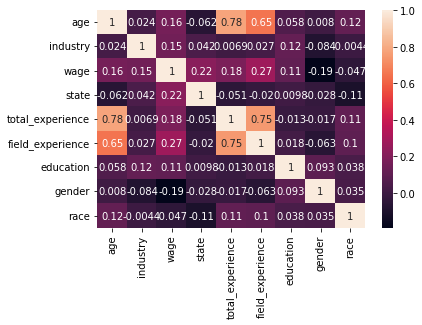

In [ ]:
sns.heatmap(df.corr(),annot=True)

The correlation matrix allows us to have some deduction. We can see the fact that wage is indeed correlated with all features, and more with the experience_in_the_field. Moreover we can add the fact that all the other features have the same influence on wage. Thus gender have the same incidence than the level of education or the global experience. 

### Try to improve our dataframe : more diversity

In [ ]:
#create a sampled dataframe with proportional proportion of genre
df_female = df[df.gender == 1]
df_nfemale = df[df.gender ==  0]
df_gender = pd.concat([df_nfemale.sample(frac = 0.75),df_female.sample(frac = 0.25)])

In [ ]:
print((df_gender.groupby('gender').size()/df_gender['gender'].count())*100)

gender
0.0    46.091906
1.0    53.908094
dtype: float64


In [ ]:
print((df_gender.groupby('race').size()/df_gender['race'].count())*100)

race
0.0    16.99292
1.0    83.00708
dtype: float64


In [ ]:
#create a sampled dataframe with proportional proportion of race

df_white = df[df.race == 1]
df_nwhite = df[df.race ==  0]
df_race = pd.concat([df_nwhite.sample(frac = 0.85),df_white.sample(frac = 0.2)])

In [ ]:
print((df_race.groupby('race').size()/df_race['race'].count())*100)

race
0.0    45.499101
1.0    54.500899
dtype: float64


In [ ]:
print((df_race.groupby('gender').size()/df_race['gender'].count())*100)

gender
0.0    22.627022
1.0    77.372978
dtype: float64


In [ ]:
#Mix them
df_diversity = pd.concat([df_gender.sample(frac = 0.5),df_race.sample(frac = 0.8)])

In [ ]:
print((df_diversity.groupby('race').size()/df_diversity['race'].count())*100)  #68% white vs 84% besore 

race
0.0    33.380398
1.0    66.619602
dtype: float64


In [ ]:
print((df_diversity.groupby('gender').size()/df_diversity['gender'].count())*100)  #66% woman vs 78% before

gender
0.0    32.756795
1.0    67.243205
dtype: float64


In [ ]:
df_diversity.shape

(8499, 9)

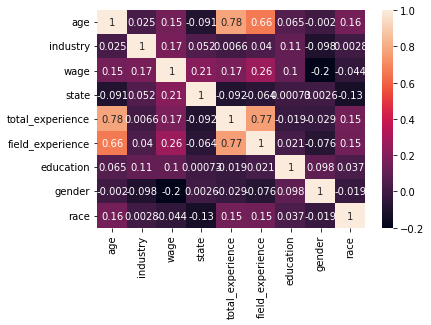

In [ ]:
sns.heatmap(df_diversity.corr(),annot=True)

We notice that gender and race influence more for diversified data than for our dataframe over-represented by white women.

## Data visualization 

In this section we will plot a certain number of graphs in order to improve our analysis. Indeed we can have an intuition for interpreting our data. It allows us to observe the behaviour of some features and it will give us an idea about which approach we'll follow.


First, we are trying to visualize if there are some clusters or some relations between the colums of our dataset.

In [ ]:
fig = px.scatter_matrix(df,
    dimensions=["age", "industry", "wage", "state", "total_experience", "field_experience"],
    color="education", width = 1500,height = 1500)
fig.show()

We use box plot in order to visualize the distribution of quantitative values. It's a useful tool to have an idea about the outliers in our data.

In [ ]:
fig = px.box(df, x="field_experience", y="wage")
fig.show()

We can observe in the following graph that the number of people with an higher experience, they have also a higher years of experience. That is something logic, this graph shows us that our data are logic.

In [ ]:
fig = px.scatter(df, x="total_experience", y="wage", color="age")
fig.show()

With the following graph we see that some industries have a part of their values higher than 300k of annual salary. On the contrary we see some other industries with a small range of distribution, taking values between 15k and 110 in terms of salary.

So we can extract some industries with a higher/lower average annual salary.

In [ ]:
fig = px.scatter(df, x="industry", y="wage")
fig.show()

Text(0.5, 1.0, 'The three worst and best sector in terms of remuneration')

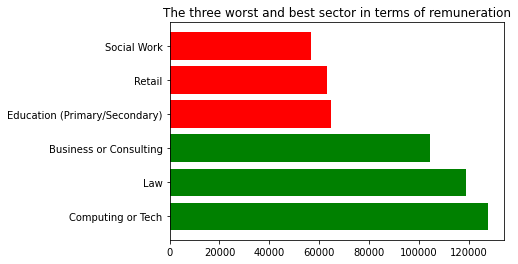

In [ ]:
df_mean = df.copy()

df_mean = round(df_mean.groupby("industry")["wage"].mean()).to_frame()
df_morepaid = df_mean.sort_values("wage", ascending = False).head(3)
df_lesspaid = df_mean.sort_values("wage", ascending = False).tail(3)

industry = ['Computing or Tech','Nonprofits','Education (Higher Education)','Health care','Accounting Banking & Finance','Government and Public Administration','Engineering or Manufacturing','Law','Marketing Advertising & PR','Education (Primary/Secondary)','Business or Consulting','Media & Digital','Insurance','Recruitment or HR','Retail','Property or Construction','Art & Design','Utilities & Telecommunications','Transport or Logistics','Sales','Social Work','Hospitality & Events','Entertainment','Agriculture or Forestry','Leisure Sport & Tourism']

df_mean = df.groupby('industry', as_index=False)['wage'].mean().sort_values("wage", ascending = False)
df_morepaid = df_mean.head(3)
df_lesspaid = df_mean.tail(3)

first_three_industries_name = []
first_three_industries_wage = []

last_three_industries_name = []
last_three_industries_wage = []

for i in range(3):
  first_three_industries_name.append(industry[25 - round(df_morepaid.industry.values[i])])
  first_three_industries_wage.append(df_morepaid.wage.values[i])

  last_three_industries_name.append(industry[25 - round(df_lesspaid.industry.values[i])])
  last_three_industries_wage.append(df_lesspaid.wage.values[i])

x = first_three_industries_name + last_three_industries_name
y = first_three_industries_wage + last_three_industries_wage
plt.barh(x,y,color=['green', 'green', 'green', 'red', 'red','red'])
plt.title('The three worst and best sector in terms of remuneration')


In the following graphs we can observe the distribution of wage with the feature gender

In [ ]:
fig = px.box(df, x="gender", y="wage")
fig.show()

With the following violin plot, we can visualize the distribution and probability Densities 

It's a way to compare the distributions between gender 0 and 1.

Here there is more people in gender 1 and with an annual wage around 75k.

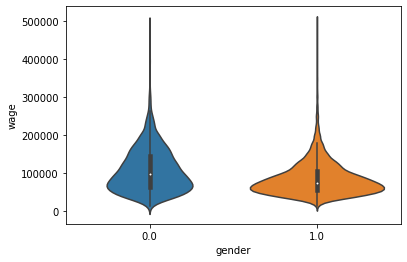

In [ ]:
sns.violinplot(x = "gender", y = "wage", data=df);

In [ ]:
fig3 = px.scatter(df, x="total_experience", y="wage", color="education")
fig3.show()

With the previous graphs, we didn't noticed relevant clusters. May be it's due to the fact that some features have an interval of values. Moreover we observe that having an higher level of education not necessarily have an higher salary.   

## US MAP

In this section we are plotting the US average annual salary map. 

First we have to clean a bit more our data to keep rows containing only one state in te column 'state'. Then we compute the average annual salary for each state and we plot it in the form of a map. 

In [ ]:
code = {'Alabama': 'AL',
        'Alaska': 'AK',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'Delaware': 'DE',
        'District of Columbia': 'DC',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY'}

a = []
for i in df1.state.unique():
  if not (i in state) :
    a.append(i)
    
df3 = df1[~df1["state"].isin(a)]
df3 = df3.astype({"wage": float})
states = df3.groupby("state").groups.keys()
s = [i for i in states]
df3 = round(df3.groupby("state")["wage"].mean()).to_frame()
df3 = df3.rename(columns={"wage": "average"})
df3["states"] = s
df3["code"] = df3['states'].map(code)

In [ ]:
fig = px.choropleth(df3,
                    locations='code',
                    color='average',
                    color_continuous_scale='spectral_r',
                    hover_name='states',
                    locationmode='USA-states',
                    labels={'average':'Average salary rate'},
                    scope='usa')

fig.add_scattergeo(
    locations=df3['code'],
    locationmode='USA-states',
    text=df3['code'],
    mode='text')

fig.update_layout(
    title={'text':'Average salary by State',
           'xanchor':'center',
           'yanchor':'top',
           'x':0.45})

fig.show()

# Regression

In [ ]:
df_reg = df

x=df_reg.drop(['wage'], axis=1)
y=df_reg.drop(['age','industry','age','total_experience','field_experience','education','gender','state','race'], axis=1)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

In [ ]:
x_train

,age,industry,state,total_experience,field_experience,education,gender,race
4024,62.5,22.0,52.0,36.0,36.0,2.0,1.0,1.0
6029,49.5,25.0,44.0,36.0,15.5,3.0,0.0,1.0
16185,29.5,18.0,48.0,6.0,6.0,3.0,1.0,0.0
10176,39.5,17.0,51.0,15.5,15.5,2.0,1.0,1.0
4382,39.5,22.0,45.0,15.5,6.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...
13123,39.5,25.0,47.0,9.0,6.0,4.0,1.0,1.0
19648,49.5,19.0,43.0,36.0,36.0,2.0,0.0,1.0
9845,39.5,21.0,39.0,15.5,15.5,2.0,1.0,1.0
10799,29.5,23.0,47.0,15.5,9.0,4.0,1.0,1.0


In [ ]:
y_train

,wage
4024,100796
6029,260000
16185,305000
10176,211000
4382,31000
...,...
13123,115000
19648,72800
9845,83000
10799,86000


##  Linear Regressor


In [ ]:
lr=LinearRegression()
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)

We can evaluate the model by plotting the original values depending on the predicted ones. The closer the points are to the bisector, the better it is.

Remark : We just chose 200 random samples to be able to read the graph.

In [ ]:
def plot_prediction_and_original(y_test, y_pred):
  number_of_samples = 200
  # random = rd.randrange(len(y_test) - number_of_samples)
  random = 0
  max_pred = 0
  if(isinstance(y_pred[0], np.ndarray)):
    max_pred = round(max(y_pred)[0])
  else:
    max_pred = round(max(y_pred))

  x_ax = [i for i in range(0, max_pred)]
  plt.scatter(y_test[random:random + number_of_samples],y_pred[random:random + number_of_samples])
  plt.plot(x_ax, x_ax, label="bisector", color='red')
  plt.xlabel("original wage")
  plt.ylabel("predicted wage")

  plt.title("Comparison of original and predicted wages")
  plt.legend()
  plt.show()


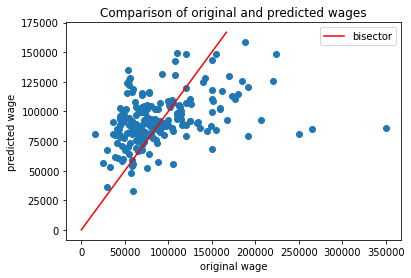

In [ ]:
plot_prediction_and_original(y_test, y_pred)

To evaluate the performance of the model, we can compute the Mean Squared Error (MSE) and Mean Absolute Error (MAE)

In [ ]:
def MSE(y_test,y_pred):
  return sum([(y_test[i] - y_pred[i])**2 for i in range(len(y_test))]) * 1/len(y_test)

def MAE(y_test,y_pred):
  return sum([abs(y_test[i] - y_pred[i]) for i in range(len(y_test))]) * 1/len(y_test)

In [ ]:
MSE(y_test.values, y_pred)

array([1.92661525e+09])

In [ ]:
MAE(y_test.values, y_pred)

array([31988.40029748])

We can see that the MAE is much smaller than the MSE. This is due to the fact that the MSE is sensitive to outliers due to the square function, unlike the MAE which uses the absolute value. 


## Decision Tree Regressor

In [ ]:
dt = DecisionTreeRegressor()
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)

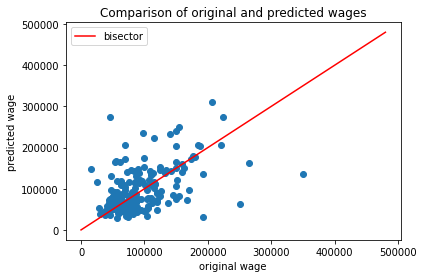

In [ ]:
plot_prediction_and_original(y_test, y_pred)

In [ ]:
MSE(y_test.values, y_pred)

array([2.52572254e+09])

In [ ]:
MAE(y_test.values, y_pred)

array([34121.55643005])

## KNN Regressor

Usually it is necessary to standardize the variables before using KNN as it uses the Euclidean distance in its algorithm. However, in our case, standardization gave the worst results. Perhaps, this could be due to the fact that some points were considered as outliers when they are not.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(x_train, y_train)
y_pred =  neigh.predict(x_test)

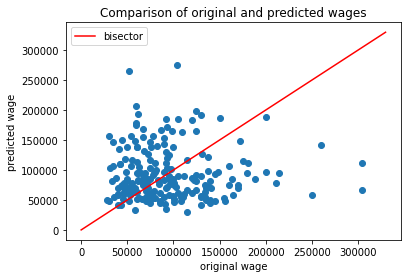

In [ ]:
plot_prediction_and_original(y_train, y_pred)

In [ ]:
MSE(y_test.values, y_pred)

array([2.2059859e+09])

In [ ]:
MAE(y_test.values, y_pred)

array([32876.53064462])

Now, let's try to find the best number of neighbors to miminize the MSE

In [ ]:
MAE_list = []
for i in range(1,50):
  neigh = KNeighborsRegressor(n_neighbors=i)
  neigh.fit(x_train, y_train)
  y_pred = neigh.predict(x_test)
  MAE_list.append(MAE(y_test.values, y_pred))

In [ ]:
fig = px.scatter(x= [i for i in range(1,50)], y=MAE_list, labels=dict(x="Number of neighbours ", y="MAE",))
fig.show()

In [ ]:
k = np.argmin(MAE_list)
print("The best number of neighbours is : " + str(k) )

The best number of neighbours is : 15


By looking at the point which minmize the MSE in the graph above, we can infer that we need to choose 15 neighbors to have better performances

In [ ]:
neigh = KNeighborsRegressor(n_neighbors=15)
neigh.fit(x_train, y_train)
y_pred = neigh.predict(x_test)

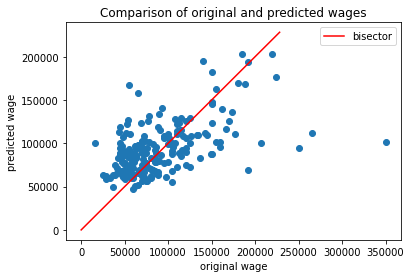

In [ ]:
plot_prediction_and_original(y_test, y_pred)

In [ ]:
MSE(y_test.values, y_pred)

array([1.7565545e+09])

In [ ]:
MAE(y_test.values, y_pred)

array([30157.31268092])

We can see that the MSE and the MAE have declined. We can also see the "f1_score_with_treshold" has increased. 

## Random Forest Regressor 

In [ ]:
regressor = RandomForestRegressor(n_estimators=10, random_state= 0)
regressor.fit(x_train,y_train.values.ravel())
y_pred = regressor.predict(x_test)

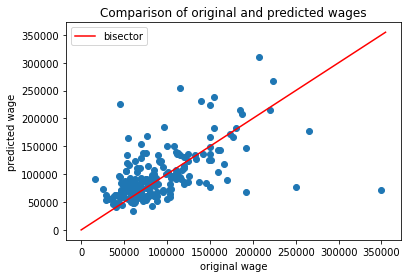

In [ ]:
plot_prediction_and_original(y_test, y_pred)

In [ ]:
MSE(y_test.values, y_pred)

array([1.71982484e+09])

In [ ]:
MAE(y_test.values, y_pred)

array([28843.08193497])

## Gradient Boost Regressor


In [ ]:
xgbr = xgb.XGBRegressor()
xgbr.fit(x_train.values, y_train.values)
score = xgbr.score(x_train.values, y_train.values)  
print("Training score: ", score)

[22:10:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training score:  0.4271511872520821


In [ ]:
y_pred = xgbr.predict(x_test.values)

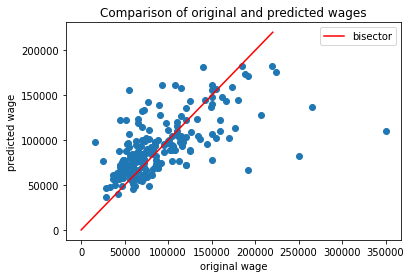

In [ ]:
plot_prediction_and_original(y_test, y_pred)

In [ ]:
MSE(y_test.values, y_pred)

array([1.38678688e+09])

In [ ]:
MAE(y_test.values, y_pred)

array([26034.64836542])

That's definitly the best results we have. So the gradient boost regressor seems to be the most appropriate method for now. 

# Accuracy improvements

## Attempt to remove outliers

The fact that our predictions are not accurate can be due to a high number of outliers, so we can try to filter our dataset further.

In [ ]:
df_outliers_deletion = df_reg

To improve the accuracy of the model, we can try to remove as many outliers as we can. To do that, we can try to visualize outliers thanks to box plots. We then keep only the points which are between the minimum and the upper fence. For instance, for the people who have field_experience = 2, we remove all the data where the wage is greater than 142 000.


In [ ]:
fig = px.box(df_outliers_deletion, x="field_experience", y="wage")
fig.show()

In [ ]:
df_to_delete = df_outliers_deletion[~(((df_outliers_deletion.field_experience == 2) & (df_outliers_deletion.wage < 142000)) | ((df_outliers_deletion.field_experience == 6) & (df_outliers_deletion.wage < 171000)) | ((df_outliers_deletion.field_experience == 9) & (df_outliers_deletion.wage < 204000)) | ((df_outliers_deletion.field_experience == 15.5) & (df_outliers_deletion.wage < 226000)) | ((df_outliers_deletion.field_experience == 36) & (df_outliers_deletion.wage < 260000)))]

In [ ]:
df_outliers_deletion =  df_outliers_deletion[((df_outliers_deletion.field_experience == 2) & (df_outliers_deletion.wage < 142000)) | ((df_outliers_deletion.field_experience == 6) & (df_outliers_deletion.wage < 171000)) | ((df_outliers_deletion.field_experience == 9) & (df_outliers_deletion.wage < 204000)) | ((df_outliers_deletion.field_experience == 15.5) & (df_outliers_deletion.wage < 226000)) | ((df_outliers_deletion.field_experience == 36) & (df_outliers_deletion.wage < 260000)) ]

In [ ]:
(df_outliers_deletion.groupby('field_experience').size()/df_outliers_deletion['field_experience'].count())*100

field_experience
2.0     26.102559
6.0     23.434575
9.0     18.103807
15.5    23.970252
36.0     8.388808
dtype: float64

In [ ]:
x=df_outliers_deletion.drop(['wage'], axis=1)

In [ ]:
y=df_outliers_deletion.drop(['age','industry','age','total_experience','field_experience','education','gender','state','race'], axis=1)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

In [ ]:
xgbr = xgb.XGBRegressor(max_depth = 5, subsample = 0.85)
xgbr.fit(x_train.values, y_train.values)
score = xgbr.score(x_train.values, y_train.values)  
print("Training score: ", score)

[22:10:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training score:  0.5414633034370695


In [ ]:
y_pred = xgbr.predict(x_test.values)

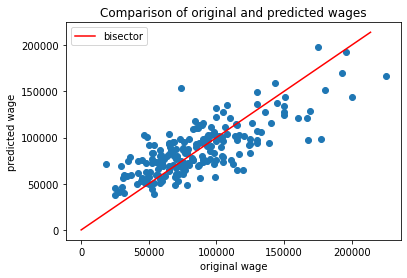

In [ ]:
plot_prediction_and_original(y_test, y_pred)

In [ ]:
MSE(y_test.values, y_pred)

array([8.40762935e+08])

In [ ]:
MAE(y_test.values, y_pred)

array([21940.86652122])

In [ ]:
print("Percentage of data removed : " + str(1 - len(df_outliers_deletion)/len(df_reg)))

Percentage of data removed : 0.0365768113037378


Even if the results are a bit better, this does not necessarily justify all the data we have removed. Indeed, we deleted about 3.66 % of the data. 

In [ ]:
((df_to_delete.groupby('state').size()/df_to_delete['state'].count())*100).sort_values(ascending = False).head(3) #Proportion of the three top states 

state
52.0    31.917808
51.0    21.095890
47.0     7.808219
dtype: float64


The majority of the data removed was people working in the following states :
*   52 : California
*   51 : New York
*   51 : Washington

They actually are the three states which pay the most.


In [ ]:
((df_to_delete.groupby('industry').size()/df_to_delete['industry'].count())*100).sort_values(ascending = False).head(3) #Proportion of the three top industries 

industry
25.0    46.986301
18.0    18.219178
22.0     7.123288
dtype: float64


The majority of the data removed was people working in the following industries :
*   25 : Computer Science and Tech
*   51 : Law
*   51 : Health Care

They are also one the industries which pay the most.

Finally, the suppressed data are people working in both the field and in the industries where managers earn the highest salaries. **Therefore, the removed data cannot be considered as outliers.**

## Forecast wage for a specific segmentation : white woman living in the USA

Even if we lose a lot of data, we can try to restrict ourselves to a specific part of the managers, in this case white women as they represent the largest part of our data.

In [ ]:
df_ww = df[(df.race == 1) & (df.gender ==1)] #We keep only the white woman

In [ ]:
df_ww

,age,industry,wage,state,total_experience,field_experience,education,gender,race
0,49.5,9.0,59000,52.0,36.0,36.0,2.0,1.0,1.0
1,49.5,13.0,73000,40.0,36.0,36.0,1.0,1.0,1.0
2,39.5,20.0,70000,50.0,9.0,9.0,4.0,1.0,1.0
3,20.0,18.0,65000,43.0,2.0,2.0,4.0,1.0,1.0
5,39.5,22.0,76000,33.0,15.5,15.5,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
19950,29.5,25.0,115000,34.0,15.5,6.0,2.0,1.0,1.0
19952,29.5,24.0,63500,47.0,6.0,2.0,2.0,1.0,1.0
19953,29.5,22.0,70100,43.0,9.0,9.0,2.0,1.0,1.0
19954,39.5,9.0,125000,40.0,15.5,9.0,2.0,1.0,1.0


In [ ]:
x=df_ww.drop(['wage','race','gender'], axis=1) #We drop race and gender because we are focusing on white womans

In [ ]:
y=df_ww[['wage']]

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

In [ ]:
xgbr = xgb.XGBRegressor(max_depth = 5, subsample = 0.85)
xgbr.fit(x_train, y_train.values)
y_pred = xgbr.predict(x_test)

score = xgbr.score(x_train, y_train.values)  
print("Training score: ", score)

[22:10:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training score:  0.4883121420121258


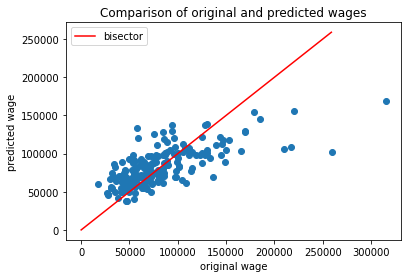

In [ ]:
plot_prediction_and_original(y_test, y_pred)

In [ ]:
MSE(y_test.values, y_pred)

array([1.29433602e+09])

In [ ]:
MAE(y_test.values, y_pred)

array([24215.60045737])

We can see that the MAE didn't decrease so much. So we should avoid to restrict ourselves to this specific part of the population. 

## One hot Encoding 

One of the issues about the dataset is how we map to each industry and each state a number. Indeed, some states and industries have higher numbers than the others, so the algorithm could consider the states and industries with the higher number as the most important ones, which is not necessarily the case. To solve this problem, we can use the one hot encoding. 


In [ ]:
df_one_hot_encoding = df

In [ ]:
for i in range(2, len(df_one_hot_encoding.state.unique()) + 2):
  df_one_hot_encoding['isInState' + str(i)] = np.where(df_one_hot_encoding.state == i,  1, 0)


In [ ]:
for i in range(1, len(df_one_hot_encoding.industry.unique()) + 1):
  df_one_hot_encoding['isInIndustry' + str(i)] = np.where(df_one_hot_encoding.industry == i,  1, 0)

In [ ]:
df_one_hot_encoding

,age,industry,wage,state,total_experience,field_experience,education,gender,race,isInState2,isInState3,isInState4,isInState5,isInState6,isInState7,isInState8,isInState9,isInState10,isInState11,isInState12,isInState13,isInState14,isInState15,isInState16,isInState17,isInState18,isInState19,isInState20,isInState21,isInState22,isInState23,isInState24,isInState25,isInState26,isInState27,isInState28,isInState29,isInState30,isInState31,isInState32,...,isInState38,isInState39,isInState40,isInState41,isInState42,isInState43,isInState44,isInState45,isInState46,isInState47,isInState48,isInState49,isInState50,isInState51,isInState52,isInIndustry1,isInIndustry2,isInIndustry3,isInIndustry4,isInIndustry5,isInIndustry6,isInIndustry7,isInIndustry8,isInIndustry9,isInIndustry10,isInIndustry11,isInIndustry12,isInIndustry13,isInIndustry14,isInIndustry15,isInIndustry16,isInIndustry17,isInIndustry18,isInIndustry19,isInIndustry20,isInIndustry21,isInIndustry22,isInIndustry23,isInIndustry24,isInIndustry25
0,49.5,9.0,59000,52.0,36.0,36.0,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,49.5,13.0,73000,40.0,36.0,36.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,39.5,20.0,70000,50.0,9.0,9.0,4.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,20.0,18.0,65000,43.0,2.0,2.0,4.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,39.5,18.0,120000,51.0,15.5,9.0,4.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19953,29.5,22.0,70100,43.0,9.0,9.0,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
19954,39.5,9.0,125000,40.0,15.5,9.0,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19955,39.5,9.0,45000,51.0,15.5,6.0,2.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19956,29.5,19.0,77000,21.0,6.0,6.0,2.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
x=df_one_hot_encoding.drop(['wage'], axis=1)

In [ ]:
y=df_one_hot_encoding[['wage']]

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

In [ ]:
x_train

,age,industry,state,total_experience,field_experience,education,gender,race,isInState2,isInState3,isInState4,isInState5,isInState6,isInState7,isInState8,isInState9,isInState10,isInState11,isInState12,isInState13,isInState14,isInState15,isInState16,isInState17,isInState18,isInState19,isInState20,isInState21,isInState22,isInState23,isInState24,isInState25,isInState26,isInState27,isInState28,isInState29,isInState30,isInState31,isInState32,isInState33,...,isInState38,isInState39,isInState40,isInState41,isInState42,isInState43,isInState44,isInState45,isInState46,isInState47,isInState48,isInState49,isInState50,isInState51,isInState52,isInIndustry1,isInIndustry2,isInIndustry3,isInIndustry4,isInIndustry5,isInIndustry6,isInIndustry7,isInIndustry8,isInIndustry9,isInIndustry10,isInIndustry11,isInIndustry12,isInIndustry13,isInIndustry14,isInIndustry15,isInIndustry16,isInIndustry17,isInIndustry18,isInIndustry19,isInIndustry20,isInIndustry21,isInIndustry22,isInIndustry23,isInIndustry24,isInIndustry25
4024,62.5,22.0,52.0,36.0,36.0,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6029,49.5,25.0,44.0,36.0,15.5,3.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
16185,29.5,18.0,48.0,6.0,6.0,3.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
10176,39.5,17.0,51.0,15.5,15.5,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4382,39.5,22.0,45.0,15.5,6.0,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,39.5,25.0,47.0,9.0,6.0,4.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
19648,49.5,19.0,43.0,36.0,36.0,2.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9845,39.5,21.0,39.0,15.5,15.5,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
10799,29.5,23.0,47.0,15.5,9.0,4.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
y_train

,wage
4024,100796
6029,260000
16185,305000
10176,211000
4382,31000
...,...
13123,115000
19648,72800
9845,83000
10799,86000


In [ ]:
xgbr = xgb.XGBRegressor()
xgbr.fit(x_train.values, y_train.values)
score = xgbr.score(x_train.values, y_train.values)  
print("Training score: ", score)

[22:10:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training score:  0.4336470511517241


In [ ]:
y_pred = xgbr.predict(x_test.values)

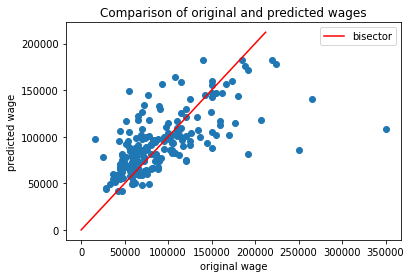

In [ ]:
plot_prediction_and_original(y_test, y_pred)

In [ ]:
MSE(y_test.values, y_pred)

array([1.37914433e+09])

In [ ]:
MAE(y_test.values, y_pred)

array([25909.02958162])

##Gradient boosting hyperparameter tuning 

***Be careful, this part take a lot of time to run***

The goal of this section is to find the parameters of XGBRegressor such that the MAE is minimized. We took some part of the code from https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f and change some values because our dataset is much smaller than in the article. Therefore, we can do more calculus , and thus find better paremeters.


We will focus only on 5 parameters :
 


*   max_depth : The maximum depth of trees
*   min_child_weight : The minimum number of samples to create a new node
*   subsample : The fraction of observations to subsample at each step
*   colsample_bytree : The fraction of features used at each step
*   eta : Influence the learning rate








In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [ ]:
y_train

,wage
4024,100796
6029,260000
16185,305000
10176,211000
4382,31000
...,...
13123,115000
19648,72800
9845,83000
10799,86000


In [ ]:
params = {
    
    'max_depth':5,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 0.85,
    'colsample_bytree': 1,
    'objective':'reg:squarederror',
}

In [ ]:
params['eval_metric'] = "mae"
num_boost_round = 1200

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=20
)

[0]	Test-mae:63227
Will train until Test-mae hasn't improved in 20 rounds.
[1]	Test-mae:45038.2
[2]	Test-mae:34875.8
[3]	Test-mae:29878.9
[4]	Test-mae:27583.4
[5]	Test-mae:26597.7
[6]	Test-mae:26170.8
[7]	Test-mae:26008.8
[8]	Test-mae:25942.4
[9]	Test-mae:25999.5
[10]	Test-mae:25990.8
[11]	Test-mae:25971.3
[12]	Test-mae:25924.7
[13]	Test-mae:25875.4
[14]	Test-mae:25865.1
[15]	Test-mae:25814.6
[16]	Test-mae:25787.2
[17]	Test-mae:25734.5
[18]	Test-mae:25692.6
[19]	Test-mae:25688.1
[20]	Test-mae:25650
[21]	Test-mae:25619.1
[22]	Test-mae:25595.2
[23]	Test-mae:25605.4
[24]	Test-mae:25553
[25]	Test-mae:25549.5
[26]	Test-mae:25531.7
[27]	Test-mae:25535.7
[28]	Test-mae:25526.6
[29]	Test-mae:25509.5
[30]	Test-mae:25495.4
[31]	Test-mae:25481.9
[32]	Test-mae:25517.9
[33]	Test-mae:25516.8
[34]	Test-mae:25492.8
[35]	Test-mae:25492.9
[36]	Test-mae:25500.6
[37]	Test-mae:25523.4
[38]	Test-mae:25523.8
[39]	Test-mae:25539.7
[40]	Test-mae:25525.1
[41]	Test-mae:25520
[42]	Test-mae:25511.7
[43]	Test-mae:25

In [ ]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(4,12)
    for min_child_weight in range(4,9)
]

In [ ]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=15
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=4, min_child_weight=4
	MAE 25605.9632814 for 49 rounds
CV with max_depth=4, min_child_weight=5
	MAE 25533.303125 for 50 rounds
CV with max_depth=4, min_child_weight=6
	MAE 25552.5496094 for 58 rounds
CV with max_depth=4, min_child_weight=7
	MAE 25536.8273438 for 58 rounds
CV with max_depth=4, min_child_weight=8
	MAE 25538.100780999997 for 46 rounds
CV with max_depth=5, min_child_weight=4
	MAE 25550.503515800003 for 32 rounds
CV with max_depth=5, min_child_weight=5
	MAE 25571.203906400002 for 38 rounds
CV with max_depth=5, min_child_weight=6
	MAE 25587.730859199997 for 37 rounds
CV with max_depth=5, min_child_weight=7
	MAE 25620.760547 for 37 rounds
CV with max_depth=5, min_child_weight=8
	MAE 25570.200781400003 for 37 rounds
CV with max_depth=6, min_child_weight=4
	MAE 25667.2722656 for 26 rounds
CV with max_depth=6, min_child_weight=5
	MAE 25690.8546874 for 30 rounds
CV with max_depth=6, min_child_weight=6
	MAE 25644.1804688 for 24 rounds
CV with max_depth=6, min_chi

In [ ]:
params['max_depth'] = 4
params['min_child_weight'] = 5

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(3,11)]
    for colsample in [i/10. for i in range(3,11)]
]

In [ ]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
	MAE 25524.4582032 for 62 rounds
CV with subsample=1.0, colsample=0.9
	MAE 25477.5671876 for 64 rounds
CV with subsample=1.0, colsample=0.8
	MAE 25567.664452999998 for 59 rounds
CV with subsample=1.0, colsample=0.7
	MAE 25550.1722656 for 74 rounds
CV with subsample=1.0, colsample=0.6
	MAE 25495.5867188 for 70 rounds
CV with subsample=1.0, colsample=0.5
	MAE 25464.194922000002 for 68 rounds
CV with subsample=1.0, colsample=0.4
	MAE 25423.41875 for 62 rounds
CV with subsample=1.0, colsample=0.3
	MAE 25542.077344 for 74 rounds
CV with subsample=0.9, colsample=1.0
	MAE 25654.864843800002 for 58 rounds
CV with subsample=0.9, colsample=0.9
	MAE 25537.4226562 for 65 rounds
CV with subsample=0.9, colsample=0.8
	MAE 25476.232812399998 for 53 rounds
CV with subsample=0.9, colsample=0.7
	MAE 25443.41875 for 58 rounds
CV with subsample=0.9, colsample=0.6
	MAE 25576.593359600003 for 62 rounds
CV with subsample=0.9, colsample=0.5
	MAE 25553.685546599998 for 64 ro

In [ ]:
params['subsample'] = 1    
params['colsample_bytree'] = 0.4

In [ ]:
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, 0.03, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    
    # Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds=10
          )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CV with eta=0.3
	MAE 25423.41875 for 62 rounds

CV with eta=0.2
	MAE 25413.238280999998 for 123 rounds

CV with eta=0.1
	MAE 25352.3324222 for 240 rounds

CV with eta=0.05
	MAE 25358.8035156 for 459 rounds

CV with eta=0.01
	MAE 25463.61875 for 1199 rounds

CV with eta=0.03
	MAE 25346.1597656 for 688 rounds

CV with eta=0.005
	MAE 25920.760546600002 for 1199 rounds

Best params: 0.03, MAE: 25346.1597656


In [ ]:
params['eta'] = 0.03

In [ ]:
params

{'colsample_bytree': 0.4,
 'eta': 0.03,
 'eval_metric': 'mae',
 'max_depth': 4,
 'min_child_weight': 5,
 'objective': 'reg:squarederror',
 'subsample': 1}

In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-mae:87930.3
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:85255.4
[2]	Test-mae:82654.2
[3]	Test-mae:80139.3
[4]	Test-mae:77692.3
[5]	Test-mae:75319.5
[6]	Test-mae:73022.6
[7]	Test-mae:70792.7
[8]	Test-mae:68639.5
[9]	Test-mae:66550.4
[10]	Test-mae:64530.7
[11]	Test-mae:62573.9
[12]	Test-mae:60686.2
[13]	Test-mae:58858.4
[14]	Test-mae:57101.4
[15]	Test-mae:55414
[16]	Test-mae:53788.4
[17]	Test-mae:52236.9
[18]	Test-mae:50744.6
[19]	Test-mae:49331.9
[20]	Test-mae:47981.3
[21]	Test-mae:46694.1
[22]	Test-mae:45458
[23]	Test-mae:44287.8
[24]	Test-mae:43165.9
[25]	Test-mae:42104.5
[26]	Test-mae:41109.8
[27]	Test-mae:40157.8
[28]	Test-mae:39260.3
[29]	Test-mae:38436.9
[30]	Test-mae:37645.2
[31]	Test-mae:36919.3
[32]	Test-mae:36218.2
[33]	Test-mae:35567.5
[34]	Test-mae:34952.1
[35]	Test-mae:34373.4
[36]	Test-mae:33847
[37]	Test-mae:33358.6
[38]	Test-mae:32903.4
[39]	Test-mae:32458.8
[40]	Test-mae:32047.8
[41]	Test-mae:31675.4
[42]	Test-mae:31321.2
[43]	Test-mae:

In [ ]:
num_boost_round  = model.best_iteration + 1

In [ ]:
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-mae:87930.3
[1]	Test-mae:85255.4
[2]	Test-mae:82654.2
[3]	Test-mae:80139.3
[4]	Test-mae:77692.3
[5]	Test-mae:75319.5
[6]	Test-mae:73022.6
[7]	Test-mae:70792.7
[8]	Test-mae:68639.5
[9]	Test-mae:66550.4
[10]	Test-mae:64530.7
[11]	Test-mae:62573.9
[12]	Test-mae:60686.2
[13]	Test-mae:58858.4
[14]	Test-mae:57101.4
[15]	Test-mae:55414
[16]	Test-mae:53788.4
[17]	Test-mae:52236.9
[18]	Test-mae:50744.6
[19]	Test-mae:49331.9
[20]	Test-mae:47981.3
[21]	Test-mae:46694.1
[22]	Test-mae:45458
[23]	Test-mae:44287.8
[24]	Test-mae:43165.9
[25]	Test-mae:42104.5
[26]	Test-mae:41109.8
[27]	Test-mae:40157.8
[28]	Test-mae:39260.3
[29]	Test-mae:38436.9
[30]	Test-mae:37645.2
[31]	Test-mae:36919.3
[32]	Test-mae:36218.2
[33]	Test-mae:35567.5
[34]	Test-mae:34952.1
[35]	Test-mae:34373.4
[36]	Test-mae:33847
[37]	Test-mae:33358.6
[38]	Test-mae:32903.4
[39]	Test-mae:32458.8
[40]	Test-mae:32047.8
[41]	Test-mae:31675.4
[42]	Test-mae:31321.2
[43]	Test-mae:31004.1
[44]	Test-mae:30709.1
[45]	Test-mae:30417.6
[46]

In [ ]:
best_prediction = best_model.predict(dtest)

In [ ]:
MAE(best_prediction,y_test.values)

array([25253.82361761])

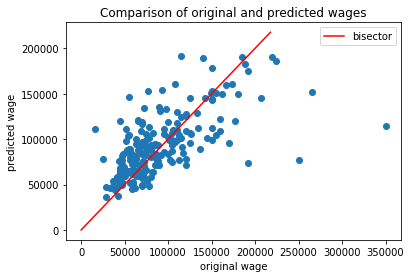

In [ ]:
plot_prediction_and_original(y_test.values, best_prediction)

In [ ]:
print("The MAE decreased by " + str(25909 - 25253))

The MAE decreased by 656


Thus, by tuning the hyperparemeters, we managed to lower the MAE by 656.

# Clustering + Classification : a new approach  

We can now try to solve the problem using a different approach. We will first try to collect different salary groups and then predict in which salary range the manager falls. 

As we have used hot encoding, we have more than 80 columns. Therefore, we should not apply k-means clustering as it will be too slow to run due to the high dimension of the space. So we will use Birch algorithm


In [ ]:
training_set = df_one_hot_encoding[:round(0.8 * len(df_one_hot_encoding))]
test_set = df_one_hot_encoding[round(0.8 * len(df_one_hot_encoding)):]

In [ ]:
nb_cluster =  6
bclust = Birch(n_clusters = nb_cluster).fit(training_set.values)
pred = bclust.predict(training_set.values)  

In [ ]:
L = []
for i in range(nb_cluster):
    L.append([])
    
for i in range(len(pred)):
    L[pred[i]].append(df_one_hot_encoding.wage[i])
print(L)
        

[[250000, 280000, 270000, 275000, 236544, 255000, 400000, 275000, 241000, 253300, 300000, 390000, 350000, 250000, 250000, 250000, 246000, 320000, 360000, 240000, 300000, 380000, 400000, 280000, 312500, 260000, 235000, 265000, 255000, 260000, 235000, 250000, 312000, 266250, 250000, 265000, 300000, 300000, 310000, 250000, 340000, 253000, 350000, 250000, 245000, 250000, 400000, 240000, 265000, 240000, 240000, 329000, 280000, 280000, 365000, 250000, 250000, 410000, 250000, 275000, 250000, 350000, 235000, 250000, 260000, 450000, 285248, 260000, 315000, 255000, 340000, 432000, 292000, 260000, 275000, 250000, 364000, 260000, 255000, 264000, 235000, 305000, 250000, 240000, 300000, 435000, 250000, 255000, 283000, 250000, 250000, 238000, 249410, 425000, 370000, 275000, 315000, 240000, 312000, 246000, 275000, 240000, 268000, 270000, 250000, 457000, 440000, 274000, 250000, 240000, 235186, 235000, 245000, 283000, 350000, 375000, 255000, 260000, 257000, 280000, 250000, 305000, 317000, 260000, 290000

In [ ]:
for i in range(len(L)):
  print(str(i) + " : " + str(len(L[i])))

0 : 276
1 : 1122
2 : 6591
3 : 2940
4 : 3478
5 : 1559


In [ ]:
for i in range(len(L)):
  print("cluster " + str(i) + " :  min wage =  " + str(min(L[i])) + "     and   max wage = " + str(max(L[i])) )

cluster 0 :  min wage =  234000     and   max wage = 499945
cluster 1 :  min wage =  160800     and   max wage = 232000
cluster 2 :  min wage =  15080     and   max wage = 71000
cluster 3 :  min wage =  94257     and   max wage = 128530
cluster 4 :  min wage =  71100     and   max wage = 94100
cluster 5 :  min wage =  129000     and   max wage = 160500


So we can identify 6 range of salaries :    
- [15080, 71000]
- [71100, 94100]
- [94257, 128350]
- [129000, 160500]
- [160800, 232000]
- [234000, inf)

In [ ]:
training_set['cluster'] = np.where((training_set['wage'] > 15080) & (training_set['wage'] < 71000),  1, 0)

training_set.loc[(training_set['wage'] > 15080) & (training_set['wage'] < 71000), 'cluster'] = 1
training_set.loc[(training_set['wage'] > 71100) & (training_set['wage'] < 94100), 'cluster'] = 2
training_set.loc[(training_set['wage'] > 94257) & (training_set['wage'] < 128350), 'cluster'] = 3
training_set.loc[(training_set['wage'] > 129000) & (training_set['wage'] < 160500), 'cluster'] = 4
training_set.loc[(training_set['wage'] > 160800) & (training_set['wage'] < 232000), 'cluster'] = 5
training_set.loc[(training_set['wage'] > 234000), 'cluster'] = 6


test_set['cluster'] = np.where((test_set['wage'] > 15080) & (test_set['wage'] < 71000),  1, 0)

test_set.loc[(test_set['wage'] > 15080) & (test_set['wage'] < 71000), 'cluster'] = 1
test_set.loc[(test_set['wage'] > 71100) & (test_set['wage'] < 94100), 'cluster'] = 2
test_set.loc[(test_set['wage'] > 94257) & (test_set['wage'] < 128350), 'cluster'] = 3
test_set.loc[(test_set['wage'] > 129000) & (test_set['wage'] < 160500), 'cluster'] = 4
test_set.loc[(test_set['wage'] > 160800) & (test_set['wage'] < 232000), 'cluster'] = 5
test_set.loc[(test_set['wage'] > 234000), 'cluster'] = 6



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [ ]:
test_set.head()

,age,industry,wage,state,total_experience,field_experience,education,gender,race,isInState2,isInState3,isInState4,isInState5,isInState6,isInState7,isInState8,isInState9,isInState10,isInState11,isInState12,isInState13,isInState14,isInState15,isInState16,isInState17,isInState18,isInState19,isInState20,isInState21,isInState22,isInState23,isInState24,isInState25,isInState26,isInState27,isInState28,isInState29,isInState30,isInState31,isInState32,...,isInState39,isInState40,isInState41,isInState42,isInState43,isInState44,isInState45,isInState46,isInState47,isInState48,isInState49,isInState50,isInState51,isInState52,isInIndustry1,isInIndustry2,isInIndustry3,isInIndustry4,isInIndustry5,isInIndustry6,isInIndustry7,isInIndustry8,isInIndustry9,isInIndustry10,isInIndustry11,isInIndustry12,isInIndustry13,isInIndustry14,isInIndustry15,isInIndustry16,isInIndustry17,isInIndustry18,isInIndustry19,isInIndustry20,isInIndustry21,isInIndustry22,isInIndustry23,isInIndustry24,isInIndustry25,cluster
15966,49.5,24.0,65000,39.0,36.0,9.0,4.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
15967,39.5,24.0,175000,48.0,36.0,9.0,4.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5
15968,29.5,3.0,90000,52.0,9.0,9.0,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
15969,29.5,5.0,64000,41.0,15.5,9.0,4.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
15970,29.5,5.0,48000,50.0,9.0,9.0,4.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
training_set = training_set[training_set.cluster != 0]
test_set = test_set[test_set.cluster != 0]

training_set = training_set.drop(['wage'],axis=1)
test_set = test_set.drop(['wage'],axis=1)

In [ ]:
test_set.cluster.unique()

array([1, 5, 2, 3, 4, 6])

In [ ]:
x_train = training_set.drop(['cluster'],axis=1)
x_test = test_set.drop(['cluster'],axis=1)
y_train = training_set.cluster
y_test = test_set.cluster

In [ ]:
xg = xgb.XGBClassifier(n_estimators=100, max_depth=4, subsample= 0.85)
xg.fit(x_train, y_train)
y_pred = xg.predict(x_test)

In [ ]:
f1_score(y_test, y_pred, average="micro")

0.48314041268243585

 The f1 score is very low. This would mean that our predictions are true one out of two times.

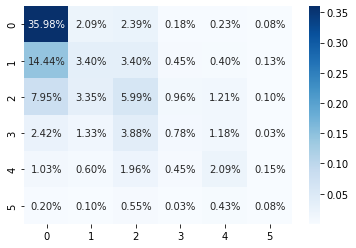

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

We can also look at the confusion matrix, and realize that a large part of  data from the cluster 1 and 2 are predicted in cluster 0. 

#Conclusion 

 
To carry out this project we all worked together jointly on the different parts. We were therefore able to help each other and bring new points of view for all sections in order to be sure to deal with the subject and to properly use our data. However, some large parts were carried by a main leader who had to go and push in detail the group's reflections and ideas, and put the associated code in order. Thus, the cleaning part was at the expense of Salhia, the visualization part at Amarnathe, and the regression part at Sofiene. About clustering and improvement methods, we collectively have tried different approaches.
 
In the first part, we were able to study quite well the influence of the features on the salary of a manager in the USA. Nevertheless, for the second part of the project, after all our attempts, applying several algorithms, trying different ways of representing our data, trying to optimize the Gradient Boosting algorithm or trying the classification approach, we are still not able to predict the salary of a manager in the USA. 
 
Perhaps the accuracy of our predictions would have been improved if we had precise numbers for the features age, field_experience, total_experience instead of intervals. Finally, even though all our approaches failed, it pushed us to outdo ourselves each time by learning new algorithms and concepts that we might never have learned if everything had worked.
